SMOTE using refined labels

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [8]:
import os, pickle, itertools
import numpy as np
import pandas as pd

import smote_variants as sv

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.inspection import permutation_importance
import sklearn.inspection as ip

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os_poly = sv.MulticlassOversampling(sv.polynom_fit_SMOTE())
os_pws = sv.MulticlassOversampling(sv.ProWSyn())

In [4]:
model_rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

## site as labels

In [5]:
filepath = '/Users/bogao/DataFiles/new landscape/files/multiclass_refined_labels.pkl'
# filepath = '/Users/bogao/DataFiles/new landscape/files/multiclass_refined_genes_labels.pkl'

with open(filepath, 'rb') as fin:
    data = pickle.load(fin)

In [8]:
results = []
spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.3)

for train_index, test_index in spliter.split(data['data'], data['target']):
    X_train, X_test = data['data'][train_index], data['data'][test_index]
    y_train, y_test = data['target'][train_index], data['target'][test_index]
    
    X_samp, y_samp = os_poly.sample(X_train, y_train)
    
    model_rf.fit(X_samp, y_samp)
    y_pred = model_rf.predict(X_test)
    
    results.append([y_test, y_pred])

2020-08-14 12:37:31,283:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-08-14 12:37:31,393:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-08-14 12:37:31,484:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
2020-08-14 12:37:31,905:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-08-14 12:37:32,011:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4072743601257297, 'topology': 'star', 'random_state': None}")
2020-08-14 12:37:32,393:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-14 12:37:32,506:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 12:37:32,901:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 12:

2020-08-14 12:39:25,680:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
2020-08-14 12:39:25,885:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-08-14 12:39:25,928:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4072743601257297, 'topology': 'star', 'random_state': None}")
2020-08-14 12:39:26,149:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-14 12:39:26,211:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 12:39:26,460:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 12:39:26,539:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-14 12:39:26,814:INFO:MulticlassOversampling: Sam

In [13]:
for r in results:
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(r[0], r[1])))
    print('Precision: {:.4f}'.format(metrics.precision_score(r[0], r[1], average='macro')))
    print('Recall: {:.4f}'.format(metrics.recall_score(r[0], r[1], average='macro')))
    print('F1: {:.4f}'.format(metrics.f1_score(r[0], r[1], average='macro'))) 

Accuracy: 0.5448
Precision: 0.4688
Recall: 0.2315
F1: 0.2653
Accuracy: 0.5516
Precision: 0.4801
Recall: 0.2409
F1: 0.2747


## Model selection

In [9]:
oversamplers = [sv.MulticlassOversampling(sv.polynom_fit_SMOTE(proportion=0.1)),
#                 sv.MulticlassOversampling(sv.polynom_fit_SMOTE(proportion=0.2)),
#                 sv.MulticlassOversampling(sv.polynom_fit_SMOTE(proportion=0.5)),
                sv.MulticlassOversampling(sv.polynom_fit_SMOTE(proportion=1.0)),
#                 sv.MulticlassOversampling(sv.polynom_fit_SMOTE(proportion=2.0)),
                sv.MulticlassOversampling(sv.polynom_fit_SMOTE(proportion=5.0)),
                sv.MulticlassOversampling(sv.ProWSyn(proportion=0.1)),
#                 sv.MulticlassOversampling(sv.ProWSyn(proportion=0.2)),
#                 sv.MulticlassOversampling(sv.ProWSyn(proportion=0.5)),
                sv.MulticlassOversampling(sv.ProWSyn(proportion=1.0)),
#                 sv.MulticlassOversampling(sv.ProWSyn(proportion=2.0)),
                sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0))]

models = [RandomForestClassifier(n_estimators=200, n_jobs=-1),
          RandomForestClassifier(n_estimators=1000, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=31, n_jobs=-1)]


all_res = []
spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.3)

for md in models:
    model_res = []
    for ov in oversamplers:

        results = []
        for train_index, test_index in spliter.split(data['data'], data['target']):
            X_train, X_test = data['data'][train_index], data['data'][test_index]
            y_train, y_test = data['target'][train_index], data['target'][test_index]

            X_samp, y_samp = ov.sample(X_train, y_train)

            md.fit(X_samp, y_samp)
            y_pred = md.predict(X_test)

            results.append([y_test, y_pred])
        model_res.append(results)
    all_res.append(model_res)

2020-08-14 20:53:21,698:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-08-14 20:53:21,732:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-08-14 20:53:21,812:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
2020-08-14 20:53:22,045:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-08-14 20:53:22,088:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4072743601257297, 'topology': 'star', 'random_state': None}")
2020-08-14 20:53:22,302:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-14 20:53:22,367:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 20:53:22,637:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 20:

2020-08-14 20:55:17,058:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
2020-08-14 20:55:17,241:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-08-14 20:55:17,292:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4072743601257297, 'topology': 'star', 'random_state': None}")
2020-08-14 20:55:17,510:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-14 20:55:17,572:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 20:55:17,819:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 20:55:17,892:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-14 20:55:18,151:INFO:MulticlassOversampling: Sam

2020-08-14 20:57:09,669:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4072743601257297, 'topology': 'star', 'random_state': None}")
2020-08-14 20:57:09,890:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-14 20:57:09,955:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 20:57:10,214:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 20:57:10,296:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-14 20:57:10,564:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 20:57:10,656:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-14 20:57:11,035:INFO:MulticlassO

2020-08-14 20:59:02,545:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 20:59:02,793:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 20:59:02,865:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-14 20:59:03,125:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 20:59:03,212:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-14 20:59:03,594:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 20:59:03,713:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-14 20:59:04,121:INFO:Multiclass

2020-08-14 21:00:55,014:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-14 21:00:55,283:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 21:00:55,376:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-14 21:00:55,754:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 21:00:55,876:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-14 21:00:56,283:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 21:00:56,404:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-14 21:00:56,808:INFO:Multicl

2020-08-14 21:02:47,166:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-14 21:02:47,552:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 21:02:47,671:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-14 21:02:48,081:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 21:02:48,201:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-14 21:02:48,606:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-14 21:02:48,734:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-14 21:02:49,201:INFO:Multicl

2020-08-14 21:10:22,757:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 21:10:22,884:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 21:11:45,644:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 21:11:45,770:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 21:13:11,671:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-14 21:13:11,809:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 21:14:46,276:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-14 21:14:46,427:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-08-14 21:36:28,727:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.15067024128686327, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 21:38:16,684:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 21:38:16,813:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 21:39:39,335:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 21:39:39,459:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 21:41:07,354:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-14 21:41:07,487:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-08-14 22:04:31,534:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 22:04:31,655:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.15067024128686327, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 22:06:20,309:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 22:06:20,441:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 22:07:44,601:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 22:07:44,724:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 22:09:11,345:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-14 22:09:11,485:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-08-14 22:31:29,487:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.18979744936234058, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 22:33:02,120:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 22:33:02,246:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.15067024128686327, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 22:34:51,173:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 22:34:51,309:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 22:36:14,502:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 22:36:14,631:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-08-14 22:59:37,326:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 22:59:37,439:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.18979744936234058, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 23:01:12,088:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 23:01:12,217:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.15067024128686327, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 23:03:02,456:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 23:03:02,592:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 23:04:26,450:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-14 23:04:26,577:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-08-14 23:26:58,554:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.257940597770074, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 23:28:05,272:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 23:28:05,383:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.18979744936234058, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 23:29:37,898:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 23:29:38,024:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.15067024128686327, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-14 23:31:22,204:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 23:31:22,334:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-08-14 23:53:57,583:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-14 23:53:57,693:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.257940597770074, 'topology': 'star', 'random_state': None}")
2020-08-14 23:53:58,031:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-14 23:53:58,145:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-14 23:53:58,522:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-14 23:53:58,647:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-14 23:53:59,069:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-14 23:53:59,194:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1358240223

2020-08-15 00:00:49,641:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-15 00:00:49,720:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.18979744936234058, 'topology': 'star', 'random_state': None}")
2020-08-15 00:00:49,983:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-15 00:00:50,074:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-15 00:00:50,451:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-15 00:00:50,573:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-15 00:00:50,961:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 00:00:51,083:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646

2020-08-15 00:07:42,449:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-08-15 00:07:42,540:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.15067024128686327, 'topology': 'star', 'random_state': None}")
2020-08-15 00:07:42,923:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-15 00:07:43,044:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-15 00:07:43,452:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 00:07:43,573:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-15 00:07:43,981:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 00:07:44,110:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1066421

2020-08-15 00:14:35,326:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-15 00:14:35,446:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-15 00:14:35,855:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 00:14:35,978:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-15 00:14:36,387:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 00:14:36,514:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-15 00:14:36,984:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 00:14:37,528:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0948312

2020-08-15 00:21:31,932:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 00:21:32,053:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-15 00:21:32,460:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 00:21:32,590:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-15 00:21:33,063:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 00:21:33,203:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.09483128089373982, 'topology': 'star', 'random_state': None}")
2020-08-15 00:21:33,693:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 00:21:33,845:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977

2020-08-15 00:28:23,480:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 00:28:23,621:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-15 00:28:24,104:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 00:28:24,245:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.09483128089373982, 'topology': 'star', 'random_state': None}")
2020-08-15 00:28:24,737:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 00:28:24,888:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977422822915, 'topology': 'star', 'random_state': None}")
2020-08-15 00:28:25,366:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 00:28:25,528:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967

2020-08-15 00:43:46,718:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 00:45:19,649:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 00:45:19,799:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 00:47:01,333:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 00:47:01,494:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 00:48:42,909:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 00:48:43,083:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-08-15 01:20:09,945:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 01:20:10,095:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 01:21:43,117:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 01:21:43,281:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 01:23:27,197:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 01:23:27,375:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 01:25:14,334:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 01:25:14,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-08-15 01:55:23,070:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 01:56:49,555:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 01:56:49,695:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 01:58:22,259:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 01:58:22,409:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 02:00:04,949:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 02:00:05,114:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-08-15 02:31:51,029:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 02:31:51,153:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 02:33:15,393:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 02:33:15,531:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 02:34:51,917:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 02:34:52,063:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 02:36:37,158:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 02:36:37,319:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-08-15 03:06:55,634:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 03:08:15,157:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 03:08:15,284:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 03:09:41,785:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 03:09:41,924:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 03:11:15,249:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 03:11:15,397:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_

2020-08-15 03:43:12,569:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-15 03:43:12,700:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.13582402234636873, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 03:44:32,608:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 03:44:32,735:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.11908646003262642, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 03:45:58,816:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 03:45:58,955:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.10664217345064295, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 03:47:31,222:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 03:47:31,369:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-08-15 04:13:55,401:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-08-15 04:13:55,531:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.13582402234636873, 'topology': 'star', 'random_state': None}")
2020-08-15 04:13:55,966:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 04:13:56,098:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-15 04:13:56,527:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 04:13:56,675:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-15 04:13:57,204:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 04:13:57,357:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0948312

2020-08-15 04:23:11,521:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-08-15 04:23:11,647:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.11908646003262642, 'topology': 'star', 'random_state': None}")
2020-08-15 04:23:12,084:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 04:23:12,221:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-15 04:23:12,727:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 04:23:13,320:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.09483128089373982, 'topology': 'star', 'random_state': None}")
2020-08-15 04:23:13,848:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 04:23:14,018:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977

2020-08-15 04:32:38,015:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-08-15 04:32:38,151:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.10664217345064295, 'topology': 'star', 'random_state': None}")
2020-08-15 04:32:38,668:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 04:32:39,254:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.09483128089373982, 'topology': 'star', 'random_state': None}")
2020-08-15 04:32:39,782:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 04:32:39,954:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977422822915, 'topology': 'star', 'random_state': None}")
2020-08-15 04:32:40,473:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 04:32:40,657:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967

2020-08-15 04:41:58,956:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 04:41:59,531:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.09483128089373982, 'topology': 'star', 'random_state': None}")
2020-08-15 04:42:00,066:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 04:42:00,238:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977422822915, 'topology': 'star', 'random_state': None}")
2020-08-15 04:42:00,751:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 04:42:00,935:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967150496563, 'topology': 'star', 'random_state': None}")
2020-08-15 04:42:01,518:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 04:42:01,743:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030

2020-08-15 04:51:18,412:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 04:51:18,586:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977422822915, 'topology': 'star', 'random_state': None}")
2020-08-15 04:51:19,099:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 04:51:19,283:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967150496563, 'topology': 'star', 'random_state': None}")
2020-08-15 04:51:19,861:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 04:51:20,058:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030892932713, 'topology': 'star', 'random_state': None}")
2020-08-15 04:51:20,704:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 04:51:20,920:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.072653825

2020-08-15 05:00:28,830:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 05:00:29,015:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967150496563, 'topology': 'star', 'random_state': None}")
2020-08-15 05:00:29,592:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 05:00:29,787:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030892932713, 'topology': 'star', 'random_state': None}")
2020-08-15 05:00:30,432:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 05:00:30,641:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07265382588841403, 'topology': 'star', 'random_state': None}")
2020-08-15 05:00:31,283:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 05:00:31,523:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.06762777

2020-08-15 05:23:15,750:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 05:24:23,794:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 05:24:24,004:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 05:25:23,435:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 05:25:23,658:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 05:26:13,118:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 05:26:13,358:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-08-15 06:00:01,164:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 06:00:01,346:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 06:01:09,671:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 06:01:09,870:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 06:02:09,768:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 06:02:09,977:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 06:02:55,627:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 06:02:55,850:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-08-15 06:35:08,134:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 06:36:55,756:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 06:36:55,936:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 06:38:01,478:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 06:38:01,674:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 06:39:01,028:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 06:39:01,242:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-08-15 07:12:44,206:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 07:12:44,372:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 07:14:27,371:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 07:14:27,553:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 07:15:34,873:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 07:15:35,081:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 07:16:33,249:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 07:16:33,461:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-08-15 07:48:46,389:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 07:50:33,519:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 07:50:33,684:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 07:52:13,991:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 07:52:14,171:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 07:53:21,390:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 07:53:21,588:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_s

2020-08-15 08:25:58,496:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 08:25:58,651:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.09483128089373982, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 08:27:42,998:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 08:27:43,170:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0876977422822915, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 08:29:27,331:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 08:29:27,519:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.08326967150496563, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 08:30:37,220:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 08:30:37,423:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-08-15 08:53:16,974:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-08-15 08:53:17,133:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.09483128089373982, 'topology': 'star', 'random_state': None}")
2020-08-15 08:53:17,698:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 08:53:17,880:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977422822915, 'topology': 'star', 'random_state': None}")
2020-08-15 08:53:18,445:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 08:53:18,648:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967150496563, 'topology': 'star', 'random_state': None}")
2020-08-15 08:53:19,300:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 08:53:19,507:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030

2020-08-15 09:03:27,623:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-08-15 09:03:27,804:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0876977422822915, 'topology': 'star', 'random_state': None}")
2020-08-15 09:03:28,334:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 09:03:28,522:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967150496563, 'topology': 'star', 'random_state': None}")
2020-08-15 09:03:29,129:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 09:03:29,335:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030892932713, 'topology': 'star', 'random_state': None}")
2020-08-15 09:03:29,982:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 09:03:30,206:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.072653825

2020-08-15 09:13:33,653:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-08-15 09:13:33,826:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.08326967150496563, 'topology': 'star', 'random_state': None}")
2020-08-15 09:13:34,378:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 09:13:34,561:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030892932713, 'topology': 'star', 'random_state': None}")
2020-08-15 09:13:35,166:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 09:13:35,361:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07265382588841403, 'topology': 'star', 'random_state': None}")
2020-08-15 09:13:35,955:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 09:13:36,164:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.06762777

2020-08-15 09:23:21,163:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 09:23:21,343:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07829030892932713, 'topology': 'star', 'random_state': None}")
2020-08-15 09:23:21,930:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 09:23:22,120:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07265382588841403, 'topology': 'star', 'random_state': None}")
2020-08-15 09:23:22,707:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 09:23:22,913:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0676277755641685, 'topology': 'star', 'random_state': None}")
2020-08-15 09:23:23,548:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 09:23:23,767:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0642248290

2020-08-15 09:33:25,367:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 09:33:25,559:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.07265382588841403, 'topology': 'star', 'random_state': None}")
2020-08-15 09:33:26,139:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 09:33:26,346:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0676277755641685, 'topology': 'star', 'random_state': None}")
2020-08-15 09:33:26,983:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 09:33:27,198:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.06422482909950207, 'topology': 'star', 'random_state': None}")
2020-08-15 09:33:27,924:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-08-15 09:33:28,155:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.06040905424

2020-08-15 09:43:31,113:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 09:43:31,323:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.0676277755641685, 'topology': 'star', 'random_state': None}")
2020-08-15 09:43:31,975:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 09:43:32,194:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.06422482909950207, 'topology': 'star', 'random_state': None}")
2020-08-15 09:43:32,887:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-08-15 09:43:33,123:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.060409054240022776, 'topology': 'star', 'random_state': None}")
2020-08-15 09:43:33,823:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-08-15 09:43:34,074:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.057114795

2020-08-15 10:10:05,272:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 10:10:58,764:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 10:10:58,995:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06422482909950207, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 10:11:41,734:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-08-15 10:11:41,972:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060409054240022776, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 10:12:27,017:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-08-15 10:12:27,274:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.057114795083187, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_stat

2020-08-15 10:48:01,421:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 10:48:01,637:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 10:48:50,169:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 10:48:50,398:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06422482909950207, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 10:49:30,593:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-08-15 10:49:30,831:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060409054240022776, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 10:50:12,964:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-08-15 10:50:13,219:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-08-15 11:25:03,938:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 11:25:51,155:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 11:25:51,364:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 11:26:38,948:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 11:26:39,171:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06422482909950207, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 11:27:21,176:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-08-15 11:27:21,410:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060409054240022776, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_st

2020-08-15 12:03:04,225:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 12:03:04,429:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 12:03:53,142:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 12:03:53,372:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 12:04:45,052:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 12:04:45,295:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06422482909950207, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 12:05:28,853:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-08-15 12:05:29,110:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proport

2020-08-15 12:41:00,761:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 12:42:02,425:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 12:42:02,639:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 12:42:51,980:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 12:42:52,204:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 12:43:43,519:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 12:43:43,754:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06422482909950207, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_sta

2020-08-15 13:19:53,801:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-08-15 13:19:53,998:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07829030892932713, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 13:20:55,590:INFO:MulticlassOversampling: Sampling minority class with label: 1
2020-08-15 13:20:55,817:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.07265382588841403, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 13:21:45,069:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-08-15 13:21:45,294:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676277755641685, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-15 13:22:37,202:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-08-15 13:22:37,447:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propor

In [154]:
i = 0
model_names = ['RF_200', 'RF_1000', 'KNN_10', 'KNN_31']
for m in all_res:
    print('######## {} ########'.format(model_names[i]))
    j = 1
    for s in m:
        
        print('-------- Sampler {} --------'.format(j))
        for r in s:
            print('Accuracy: {:.4f}'.format(metrics.accuracy_score(r[0], r[1])))
            print('Precision: {:.4f}'.format(metrics.precision_score(r[0], r[1], average='macro')))
            print('Recall: {:.4f}'.format(metrics.recall_score(r[0], r[1], average='macro')))
            print('F1: {:.4f}'.format(metrics.f1_score(r[0], r[1], average='macro'))) 
            print()
        j = j + 1
        
    i = i + 1

######## RF_200 ########
-------- Sampler 1 --------
Accuracy: 0.5531
Precision: 0.4977
Recall: 0.2361
F1: 0.2709

Accuracy: 0.5481
Precision: 0.5048
Recall: 0.2353
F1: 0.2695

-------- Sampler 2 --------
Accuracy: 0.5447
Precision: 0.5300
Recall: 0.2342
F1: 0.2691

Accuracy: 0.5441
Precision: 0.5031
Recall: 0.2348
F1: 0.2710

-------- Sampler 3 --------
Accuracy: 0.5548
Precision: 0.5725
Recall: 0.2487
F1: 0.2896

Accuracy: 0.5497
Precision: 0.5165
Recall: 0.2479
F1: 0.2904

-------- Sampler 4 --------
Accuracy: 0.5739
Precision: 0.3996
Recall: 0.3967
F1: 0.3910

Accuracy: 0.5781
Precision: 0.4273
Recall: 0.4256
F1: 0.4183

-------- Sampler 5 --------
Accuracy: 0.5797
Precision: 0.4118
Recall: 0.4244
F1: 0.4105

Accuracy: 0.5762
Precision: 0.4397
Recall: 0.4300
F1: 0.4246

-------- Sampler 6 --------
Accuracy: 0.5742
Precision: 0.4083
Recall: 0.4035
F1: 0.4001

Accuracy: 0.5803
Precision: 0.4384
Recall: 0.4210
F1: 0.4198

######## RF_1000 ########
-------- Sampler 1 --------
Accuracy:

In [14]:
trues, pred = all_res[1][5][0]

In [15]:
cm = metrics.confusion_matrix(trues, pred)

(31.0, 0.0)

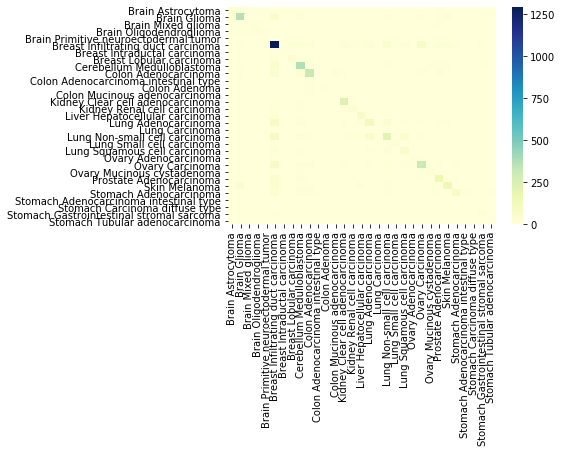

In [17]:
ax = sns.heatmap(cm , cmap="YlGnBu", xticklabels=data['name'], yticklabels=data['name'])
blim, tlim = ax.get_ylim()
ax.set_ylim(blim+0.5, tlim-0.5)

In [123]:
mcm = metrics.multilabel_confusion_matrix(trues, pred) 

In [124]:
mcm[24]

array([[6384,  143],
       [ 112,  163]])

In [25]:
prfs = metrics.precision_recall_fscore_support(trues, pred, average=None)

In [26]:
mt = pd.DataFrame({'Label':data['name'], 'Precision': prfs[0], 'Recall':prfs[1], 'F1-score':prfs[2]})

In [29]:
mt.sort_values('F1-score', ascending=False)

,Label,Precision,Recall,F1-score
13,Kidney Clear cell adenocarcinoma,0.652778,0.842294,0.735524
5,Breast Infiltrating duct carcinoma,0.657681,0.761933,0.705979
1,Brain Glioma,0.718200,0.648410,0.681523
8,Cerebellum Medulloblastoma,0.628571,0.740594,0.680000
9,Colon Adenocarcinoma,0.691649,0.655172,0.672917
22,Ovary Carcinoma,0.675381,0.583804,0.626263
6,Breast Intraductal carcinoma,0.764706,0.520000,0.619048
23,Ovary Mucinous cystadenoma,0.471698,0.714286,0.568182
24,Prostate Adenocarcinoma,0.532680,0.592727,0.561102
29,Stomach Gastrointestinal stromal sarcoma,0.509434,0.509434,0.509434


In [117]:
code = np.where(data['name'] == 'Prostate Adenocarcinoma')[0][0]+1

#### False negative

In [118]:
wrongs = []
for t, p in zip(trues, pred):
    if t == code and p != code:
        wrongs.append(p)

In [119]:
pd.DataFrame(np.unique([data['name'][x-1] for x in wrongs], return_counts=True)).transpose().rename(columns={0:'name', 1:'count'}).sort_values('count',ascending=False)

,name,count
3,Breast Infiltrating duct carcinoma,40
5,Cerebellum Medulloblastoma,16
1,Brain Glioma,12
14,Ovary Carcinoma,8
16,Stomach Adenocarcinoma,6
0,Brain Astrocytoma,5
6,Colon Adenocarcinoma,5
9,Kidney Clear cell adenocarcinoma,4
7,Colon Adenoma,2
10,Kidney Renal cell carcinoma,2


#### False positive

In [120]:
wrongs = []
for t, p in zip(y_samp, y_pred):
    if t != code and p == code:
        wrongs.append(t)

In [121]:
pd.DataFrame(np.unique([data['name'][x-1]  for x in wrongs], return_counts=True)).transpose().rename(columns={0:'name', 1:'count'}).sort_values('count',ascending=False)

,name,count
5,Breast Infiltrating duct carcinoma,48
17,Lung Non-small cell carcinoma,21
1,Brain Glioma,20
19,Ovary Carcinoma,15
8,Cerebellum Medulloblastoma,10
9,Colon Adenocarcinoma,9
21,Skin Melanoma,9
15,Lung Adenocarcinoma,8
7,Breast Lobular carcinoma,7
18,Lung Squamous cell carcinoma,4


### Overall metrics

In [ ]:
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_samp, y_pred)))
print('Precision: {:.4f}'.format(metrics.precision_score(y_samp, y_pred, average='macro')))
print('Recall: {:.4f}'.format(metrics.recall_score(y_samp, y_pred, average='macro')))
print('F1: {:.4f}'.format(metrics.f1_score(y_samp, y_pred, average='macro')))

In [ ]:
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_samp, y_pred)))
print('Precision: {:.4f}'.format(metrics.precision_score(y_samp, y_pred, average='macro')))
print('Recall: {:.4f}'.format(metrics.recall_score(y_samp, y_pred, average='macro')))
print('F1: {:.4f}'.format(metrics.f1_score(y_samp, y_pred, average='macro')))

### Confusion matrix

In [ ]:
cm = metrics.confusion_matrix(y_samp, y_pred)

In [ ]:
# ax = sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap="Blues", xticklabels=set(data['label']), yticklabels=set(data['label']))
# blim, tlim = ax.get_ylim()
# ax.set_ylim(blim+0.5, tlim-0.5)

plt.figure(figsize=(17,15))
ax = sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap="YlGnBu", xticklabels=set(data['label']), yticklabels=set(data['label']))
blim, tlim = ax.get_ylim()
ax.set_ylim(blim+0.5, tlim-0.5)
# plt.savefig('/Users/bogao/Desktop/projects/new landscape/Manuscript/performance-subtypes.pdf',bbox_inches='tight')

In [ ]:
num2label = dict([(x+1,y) for x,y in enumerate(set(data['label']))])

### Individual metrics

In [ ]:
mcm = metrics.multilabel_confusion_matrix(y_samp, y_pred)

In [ ]:
prfs = metrics.precision_recall_fscore_support(y_samp, y_pred, average=None)

In [ ]:
accs = []
for m in mcm:
    acc = (m[0,0] + m[1,1])/np.sum(m)
    accs.append(acc)

In [ ]:
mt = pd.DataFrame({'Label':list(num2label.values()), 'Accuracy':accs, 'Precision': prfs[0], 'Recall':prfs[1], 'F1-score':prfs[2]})

In [ ]:
mt.sort_values('Label')

## Organ label from disease

In [ ]:
label2num = dict([(y, x+1) for x,y in enumerate(set(data['label']))])

In [96]:
organs = []
for i in data['name']:
    organs.append(i.split(' ')[0])

In [97]:
organs = np.unique(organs)

In [98]:
organs

array(['Brain', 'Breast', 'Cerebellum', 'Colon', 'Kidney', 'Liver',
       'Lung', 'Ovary', 'Prostate', 'Skin', 'Stomach'], dtype='<U10')

In [ ]:
organ2num = dict([(y, x+1) for x,y in enumerate(set(organs))])

In [ ]:
organ2num

In [84]:
label2organ = {}
for v,i in zip(data['name'], range(len(data['name']))):
    label2organ[i] = v.split(' ')[0]

In [85]:
label2organ

{0: 'Brain',
 1: 'Brain',
 2: 'Brain',
 3: 'Brain',
 4: 'Brain',
 5: 'Breast',
 6: 'Breast',
 7: 'Breast',
 8: 'Cerebellum',
 9: 'Colon',
 10: 'Colon',
 11: 'Colon',
 12: 'Colon',
 13: 'Kidney',
 14: 'Kidney',
 15: 'Liver',
 16: 'Lung',
 17: 'Lung',
 18: 'Lung',
 19: 'Lung',
 20: 'Lung',
 21: 'Ovary',
 22: 'Ovary',
 23: 'Ovary',
 24: 'Prostate',
 25: 'Skin',
 26: 'Stomach',
 27: 'Stomach',
 28: 'Stomach',
 29: 'Stomach',
 30: 'Stomach'}

In [86]:
trues_org = [label2organ[x-1] for x in trues]

In [87]:
pred_org = [label2organ[x-1] for x in pred]

### Overall metrics

In [88]:
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(trues_org, pred_org)))
print('Precision: {:.4f}'.format(metrics.precision_score(trues_org, pred_org, average='macro')))
print('Recall: {:.4f}'.format(metrics.recall_score(trues_org, pred_org, average='macro')))
print('F1: {:.4f}'.format(metrics.f1_score(trues_org, pred_org, average='macro')))

Accuracy: 0.6751
Precision: 0.6356
Recall: 0.6338
F1: 0.6298


### Confusion matrix

In [89]:
cm = metrics.confusion_matrix(trues_org, pred_org)

(11.0, 0.0)

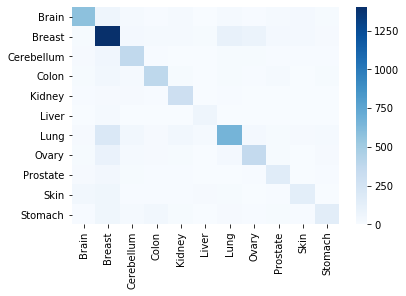

In [100]:
# sns.set(font_scale = 2)
# plt.figure(figsize=(17,15))
ax = sns.heatmap(cm, cmap="Blues", xticklabels=organs, yticklabels=organs)
blim, tlim = ax.get_ylim()
ax.set_ylim(blim+0.5, tlim-0.5)
# plt.yticks(rotation=0)
# plt.savefig('/Users/bogao/Desktop/projects/new landscape/Manuscript/performance-organs.pdf',bbox_inches='tight')

In [101]:
mcm = metrics.multilabel_confusion_matrix(trues_org, pred_org)

In [102]:
prfs = metrics.precision_recall_fscore_support(trues_org, pred_org, average=None)

In [104]:
mt = pd.DataFrame({'Label':organs, 'Precision': prfs[0], 'Recall':prfs[1], 'F1-score':prfs[2]})

In [106]:
mt.sort_values('F1-score', ascending=False)

,Label,Precision,Recall,F1-score
0,Brain,0.777630,0.717445,0.746326
1,Breast,0.678606,0.786756,0.728690
4,Kidney,0.658696,0.805851,0.724880
3,Colon,0.710866,0.705667,0.708257
2,Cerebellum,0.628571,0.740594,0.680000
6,Lung,0.742762,0.593416,0.659743
7,Ovary,0.673507,0.602671,0.636123
8,Prostate,0.532680,0.592727,0.561102
9,Skin,0.581967,0.443750,0.503546
5,Liver,0.446043,0.558559,0.496000


## Investigating mis-classifications

In [ ]:
mcm

### Breast Infiltrating duct carcinoma

In [ ]:
code = label2num['Breast Infiltrating duct carcinoma']

#### False negative

In [ ]:

wrongs = []
for t, p in zip(y_samp, y_pred):
    if t == code and p != code:
        wrongs.append(p)

In [ ]:
pd.DataFrame(np.unique([num2label[x] for x in wrongs], return_counts=True)).transpose()

#### False positive

In [ ]:
wrongs = []
for t, p in zip(y_samp, y_pred):
    if t != code and p == code:
        wrongs.append(t)

In [ ]:
pd.DataFrame(np.unique([num2label[x] for x in wrongs], return_counts=True)).transpose()

### Lung Non-small cell carcinoma

In [ ]:
code = label2num['Lung Non-small cell carcinoma']

In [ ]:
wrongs = []
for t, p in zip(y_samp, y_pred):
    if t == code and p != code:
        wrongs.append(p)

In [ ]:
pd.DataFrame(np.unique([num2label[x] for x in wrongs], return_counts=True)).transpose()

## Feature importance

In [ ]:
rf = model_rf.fit(X_samp, y_samp)

In [ ]:
rf

In [ ]:
fi = rf.feature_importances_

In [ ]:
amp_genes =  pd.read_csv('/Users/bogao/DataFiles/Data/genome/high_amp_genes.tsv', sep='\t')

del_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/high_del_genes.tsv', sep='\t')


In [ ]:
amp_genes = amp_genes.assign(type='amp')
del_genes = del_genes.assign(type='del')

In [ ]:
genes = pd.merge(amp_genes, del_genes, how='outer')

In [ ]:
genes = genes.assign(score = fi)

In [ ]:
genes.nlargest(20,'score')

## tests

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

In [ ]:
splits = sss.split(X_samp, y_samp)

In [ ]:
for train_index, test_index in splits:

    X_train, X_test = X_samp[train_index], X_samp[test_index]
    y_train, y_test = y_samp[train_index], y_samp[test_index]

In [ ]:
m = model_rf.fit(X_train, y_train)

In [ ]:
y_pred = m.predict(X_test)

In [ ]:
metrics.f1_score(y_test, y_pred, average='macro')

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')

In [ ]:
cm

In [ ]:
np.sum(cm, axis=1)

In [ ]:
sns.heatmap(cm, cmap="Blues", xticklabels=set(data['label']), yticklabels=set(data['label']))

In [ ]:
dict([(y,x+1) for x,y in enumerate(set(data['label']))])

In [ ]:
np.unique(data['label'], return_counts=True)

In [ ]:
metrics.accuracy_score(labels_test, y_predict)

In [ ]:
data['data'].shape

In [18]:
import sklearn.datasets as datasets

In [19]:
dataset= datasets.load_breast_cancer()

In [21]:
dataset.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [ ]:
d = {}
d['data'] = data['data']
d['target'] = np.array(num_labels)
d['name'] = np.array(set(data['label']))

In [ ]:
res = sv.cross_validate(d, oversampler, model_rf)

In [ ]:
res

In [ ]:
sns.heatmap(res['value']['confusion_matrix']/res['value']['confusion_matrix'].sum(axis=1, keepdims=True), cmap="Blues", xticklabels=set(data['label']), yticklabels=set(data['label']))

In [ ]:
res['value']['confusion_matrix']

In [142]:
data['data'].shape

(22671, 3029)

In [135]:
target_idx = np.where(data['target'] == 6)[0]

exclude_idx = utils.resample(target_idx, n_samples=4000, replace=False)

exclude_idx.shape

mask = np.ones(data['data'].shape[0], bool)

mask[exclude_idx] = False

us_data = data['data'][mask]

us_target = data['target'][mask]

In [159]:
us_results = []
spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.3)

for train_index, test_index in spliter.split(us_data, us_target):
    X_train, X_test = us_data[train_index], us_data[test_index]
    y_train, y_test = us_target[train_index], us_target[test_index]
    
    X_samp, y_samp = os_pws.sample(X_train, y_train)
    
    model_rf.fit(X_samp, y_samp)
    y_pred = model_rf.predict(X_test)
    
    us_results.append([y_test, y_pred])

2020-08-17 11:57:40,150:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-08-17 11:57:40,188:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-08-17 11:57:40,287:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-17 11:57:54,354:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-17 11:57:54,379:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-17 11:58:10,969:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-17 11:58:10,998:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05168700646087581, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-17 11:58:35,989:INFO:MulticlassOversampling: Sampling mi

2020-08-17 12:06:04,996:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-17 12:06:47,710:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-08-17 12:06:47,747:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-08-17 12:06:47,773:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-17 12:07:01,380:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-08-17 12:07:01,405:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")
2020-08-17 12:07:18,585:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-08-17 12:07:18,675:INFO:ProWSyn: Running sampling via ('Pro

2020-08-17 12:19:08,975:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-08-17 12:19:09,145:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': None}")


In [1]:
for r in us_results:
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(r[0], r[1])))
    print('Precision: {:.4f}'.format(metrics.precision_score(r[0], r[1], average='macro')))
    print('Recall: {:.4f}'.format(metrics.recall_score(r[0], r[1], average='macro')))
    print('F1: {:.4f}'.format(metrics.f1_score(r[0], r[1], average='macro')))

NameError: name 'us_results' is not defined

In [2]:
cm

NameError: name 'cm' is not defined